In [37]:
import pandas as pd
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import itertools
import csv


def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix\\\\")
    #else:
        #print('Confusion matrix, without normalization\\\\')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


pca = False
pca_sklearn = False
lda = False
minmaxscaler = True

#load data
df = pd.read_csv("exoplanet.csv")
df.info()
df = df.replace('CONFIRMED', 0)
df = df.replace('CANDIDATE', 1)
df = df.replace('FALSE POSITIVE', 2)
df = df.fillna(0)

df.sort_values('koi_disposition', inplace=True, ascending=False)
df = df.iloc[2500:]

df = df.sample(frac=1, random_state=42)

df.to_csv("Exoplanet_mod.csv")
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
7703,7704,8624860,K07072.01,0,1,1,0.872,0,0,0,...,-109.0,3.282,0.255,-0.085,4.994,0.631,-1.892,291.79575,44.746181,13.808
5997,5998,2158460,K04932.01,0,2,2,0.000,1,0,0,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,291.06418,37.535751,15.892
4287,4288,10120548,K04451.01,0,1,1,0.851,0,0,0,...,-136.0,4.628,0.035,-0.070,0.706,0.086,-0.058,282.19565,47.105679,15.945
5885,5886,7107561,K03100.01,0,2,2,0.000,0,1,1,...,-186.0,4.009,0.259,-0.111,1.877,0.383,-0.575,288.49313,42.692478,13.429
2878,2879,11395587,K00350.01,0,1,1,0.983,0,0,0,...,-116.0,4.402,0.090,-0.110,1.027,0.151,-0.100,287.86142,49.264462,13.387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,1746,8591693,K02123.01,0,1,1,1.000,0,0,0,...,-198.0,4.491,0.052,-0.208,0.949,0.292,-0.097,301.54297,44.605610,14.385
1937,1938,8007644,K02328.01,Kepler-1192 b,0,1,0.407,0,0,0,...,-175.0,4.517,0.048,-0.204,0.921,0.256,-0.092,282.14056,43.896580,15.684
1879,1880,10864531,K02080.01,Kepler-358 c,0,1,0.526,0,0,0,...,-193.0,4.505,0.052,-0.208,0.940,0.297,-0.099,293.23022,48.281368,15.375
267,268,8414716,K00910.01,Kepler-721 b,0,1,1.000,0,0,0,...,-155.0,4.589,0.024,-0.102,0.801,0.106,-0.057,284.43051,44.480530,15.651


In [38]:
#normalize feature with MinMaxScaler after it we need to fit the data
MinMaxScaler = preprocessing.MinMaxScaler()


y_data = pd.read_csv('Exoplanet_mod.csv', usecols= ['koi_disposition'])#.values.transpose()[0]
x_data = pd.read_csv('Exoplanet_mod.csv', usecols= ['koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec',
                                                    'koi_period','koi_period_err1','koi_period_err2','koi_time0bk',
                                                    'koi_time0bk_err1','koi_time0bk_err2','koi_impact','koi_impact_err1',
                                                    'koi_impact_err2','koi_duration','koi_duration_err1','koi_duration_err2',
                                                    'koi_depth','koi_depth_err1','koi_depth_err2','koi_prad','koi_prad_err1',
                                                    'koi_prad_err2','koi_teq','koi_teq_err1','koi_teq_err2','koi_insol',
                                                    'koi_insol_err1','koi_insol_err2','koi_model_snr','koi_tce_plnt_num',
                                                    'koi_steff','koi_steff_err1','koi_steff_err2','koi_slogg','koi_slogg_err1',
                                                    'koi_slogg_err2','koi_srad','koi_srad_err1','koi_srad_err2','ra','dec','koi_kepmag'])

#take the 80% of data for train and 20% for test
x_train = x_data[:5651]
y_train = y_data[:5651]

x_test = x_data[5651:]
y_test = y_data[5651:]

x_train = x_train.values
x_test = x_test.values

print("Classes train : ", y_train.shape)
print("Features train : ", x_train.shape)

print("Classes test :", y_test.shape)
print("Features train : ", x_test.shape)
if minmaxscaler :
    x_train = MinMaxScaler.fit_transform(x_train)
    x_test = MinMaxScaler.fit_transform(x_test)

Classes train :  (5651, 1)
Features train :  (5651, 42)
Classes test : (1413, 1)
Features train :  (1413, 42)


In [39]:
#calculate PCA with SKLEARN
if pca_sklearn :
    pca = PCA(n_components=4, svd_solver='full')
    pca_train = PCA().fit(x_train)
    pca_test = PCA().fit(x_test)

    cum_var = np.cumsum(pca_train.explained_variance_ratio_)

    plt.plot(cum_var)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

    x_train = pca_train.transform(x_train)
    x_test = pca_test.transform(x_test) 


In [40]:

if pca :
    # Calculate the mean of each feature and center the data
    m = np.mean(x_train, axis=0)
    Xc = x_train - m

    m1 = np.mean(x_test, axis=0)
    Xc_t = x_test - m1

    # Calculate the covariance matrix of the centred data
    C = np.cov(Xc, rowvar=False)
    C1 = np.cov(Xc_t, rowvar=False)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    lambdas, U = np.linalg.eigh(C)
    lambdas1, U1 = np.linalg.eigh(C1)

    # Order the eigenvalues from largest to smallest

    best_eig_idxs = np.argsort(lambdas)[::-1]
    best_eig = lambdas[best_eig_idxs]
    best_U = U[:, best_eig_idxs]

    best_eig_idxs1 = np.argsort(lambdas1)[::-1]
    best_eig1 = lambdas1[best_eig_idxs1]
    best_U1 = U1[:, best_eig_idxs1]

    # I construct the transformation matrix T: 
    T = best_U[:, :4]
    T1 = best_U1[:, :4]

    # Apply the transformation to the train data, make a scatter plot of the transformed data
    # The transformation is performed via the inner product of the transformation matrix T
    # and the (centered) data matrix
    x_train = np.dot(Xc, T)
    x_test = np.dot(Xc_t, T1)

In [41]:
#calculate LDA with SKLEARN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
if lda :
    lda = LinearDiscriminantAnalysis(n_components=2)
    lda.fit(x_train, y_train)
    x_train = lda.transform(x_train)
    x_test = lda.transform(x_test)

[LibSVM][LibSVM][LibSVM]

################# rbf #################

              precision    recall  f1-score   support

           0       0.82      0.62      0.70       472
           1       0.69      0.80      0.74       471
           2       0.90      0.99      0.94       470

    accuracy                           0.80      1413
   macro avg       0.80      0.80      0.80      1413
weighted avg       0.80      0.80      0.80      1413



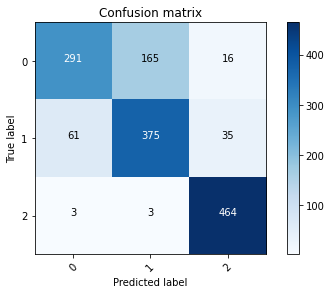

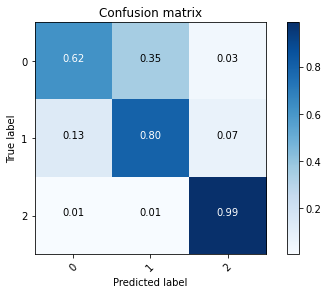

[LibSVM][LibSVM][LibSVM]

################# poly3 #################

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       472
           1       0.74      0.68      0.71       471
           2       0.95      0.97      0.96       470

    accuracy                           0.80      1413
   macro avg       0.80      0.80      0.80      1413
weighted avg       0.80      0.80      0.80      1413



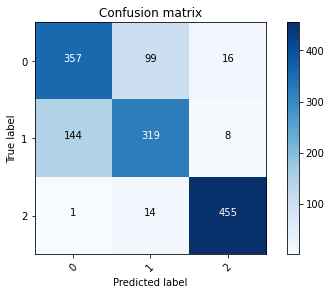

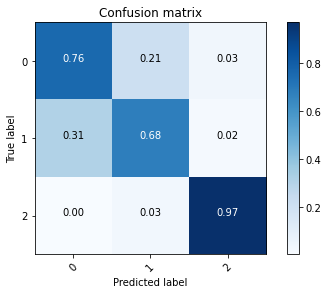

[LibSVM][LibSVM][LibSVM]

################# poly5 #################

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       472
           1       0.76      0.73      0.75       471
           2       0.94      0.97      0.96       470

    accuracy                           0.82      1413
   macro avg       0.82      0.82      0.82      1413
weighted avg       0.82      0.82      0.82      1413



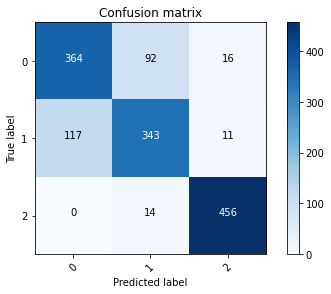

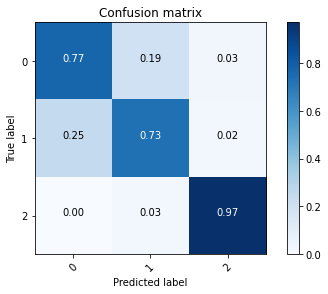

[LibSVM][LibSVM][LibSVM]

################# sigmoid #################

              precision    recall  f1-score   support

           0       0.55      0.93      0.69       472
           1       0.81      0.22      0.34       471
           2       0.95      0.98      0.96       470

    accuracy                           0.71      1413
   macro avg       0.77      0.71      0.66      1413
weighted avg       0.77      0.71      0.66      1413



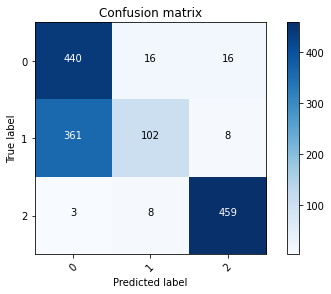

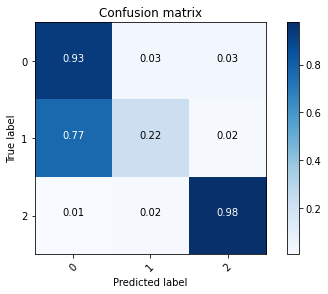

[LibSVM][LibSVM][LibSVM]

################# linear #################

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       472
           1       0.76      0.64      0.70       471
           2       0.95      0.97      0.96       470

    accuracy                           0.80      1413
   macro avg       0.80      0.80      0.80      1413
weighted avg       0.80      0.80      0.80      1413



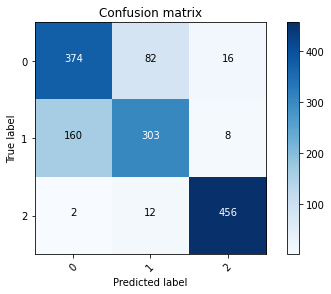

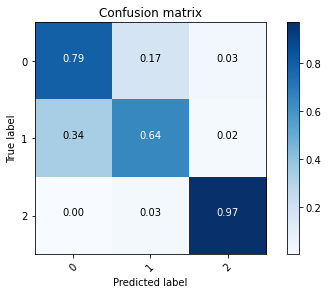

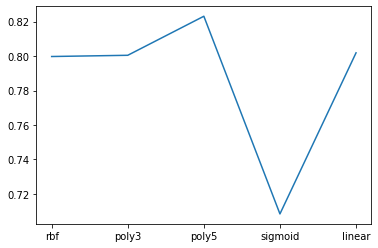

In [42]:
#Classifier
kernels = ["rbf","poly3","poly5","sigmoid","linear"]

classes = ['0','1','2']

test_accuracy = np.empty(len(kernels))
max_iteration = -1
i=0

for fun in kernels:
    if fun == 'poly3':
        model = OneVsRestClassifier(SVC(kernel='poly', degree=3, max_iter=max_iteration, probability=False, verbose=True)).fit(x_train,y_train)
    elif fun == 'rbf':
        model = OneVsRestClassifier(SVC(kernel='rbf', max_iter=max_iteration, probability=False, verbose=True,  C=30, gamma=1.5)).fit(x_train,y_train)
    elif fun == 'poly5':
        model = OneVsRestClassifier(SVC(kernel='poly', degree=5, max_iter=max_iteration, probability=False, verbose=True)).fit(x_train,y_train)
    else:
        model = OneVsRestClassifier(SVC(kernel=fun, max_iter=max_iteration, probability=False, verbose=True)).fit(x_train,y_train)
    predict = model.predict(x_test)

    classification_metrics = metrics.classification_report(y_test, np.round(predict), target_names=classes)
    print("\n\n#################", fun ,"#################")
    print("\n" + classification_metrics)

    confusion_matrix= metrics.confusion_matrix(y_test, predict)

    plot_confusion_matrix(confusion_matrix, classes)
    plt.show()
    plot_confusion_matrix(confusion_matrix, classes, normalize=True)
    plt.show()

    test_accuracy[i] = model.score(x_test, y_test)
    i = i+1

plt.plot(kernels, test_accuracy, label = 'Testing dataset Accuracy')